In [42]:
import sys
import numpy as np
import pandas as pd
import glob
import os
from nilearn import image
from nilearn.glm import threshold_stats_img
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map
sys.path.append('..')
from utils.data import load_participant_list

# Parameters

In [43]:
statistic = 'z_score'
multiple_comp_corr = 'fdr'
alpha = 0.05
run = 'test'
first_level_dir = '/home/ubuntu/data/learning-habits/outputs/first_level/QC_cloud-23.2.1_brain_masked/'

# Load First level data

In [44]:
base_dir = '/home/ubuntu/data/learning-habits'
all_sub_ids = load_participant_list(base_dir)
sub_ids = all_sub_ids

In [45]:
zscores_paths = [
    glob.glob(os.path.join(first_level_dir, f"sub-{sub_id}_run-{run}*_b_map.nii.gz"))[0]
    for sub_id in sub_ids
]
zscores_paths.sort()


In [46]:
zscore_maps = [image.load_img(path) for path in zscores_paths]

# Second level - Button press

In [47]:
X_response = pd.DataFrame([1] * len(zscore_maps), columns=['Intercept'])

In [48]:
model2 = SecondLevelModel()
model2 = model2.fit(zscore_maps, design_matrix=X_response)

In [49]:
response_map = model2.compute_contrast('Intercept',output_type='z_score')

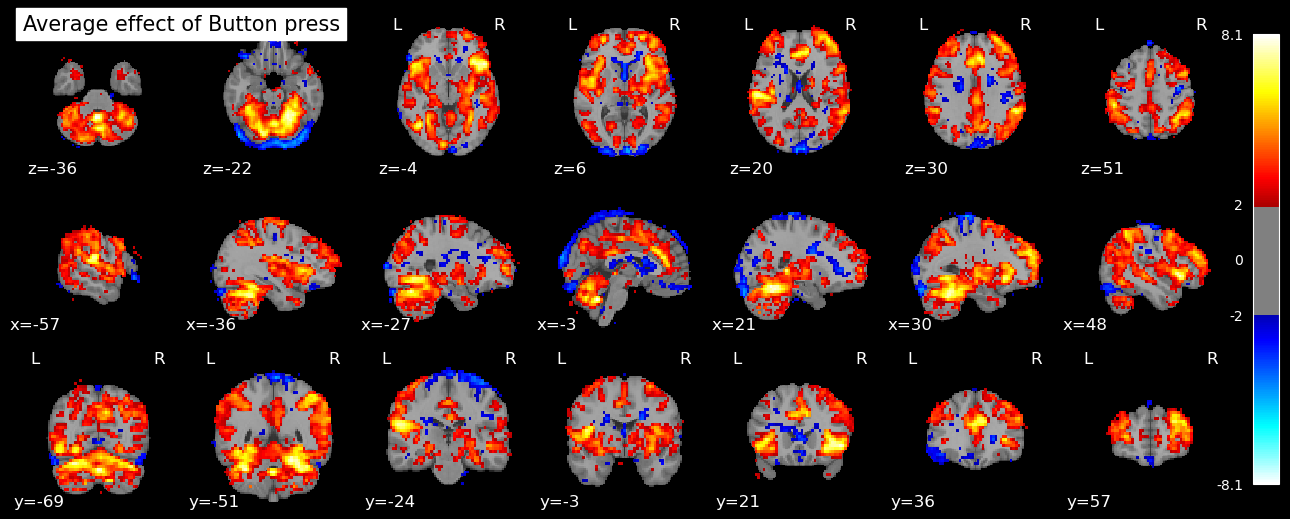

In [50]:
plot_stat_map(response_map, threshold=2, black_bg=True, display_mode='mosaic', title='Average effect of Button press')

In [51]:
thresholded_zmap, threshold = threshold_stats_img(response_map, alpha=0.05, height_control='bonferroni', cluster_threshold=20)
print(f"RL whole brain Bonferroni threshold: {threshold:.3f}")

RL whole brain Bonferroni threshold: 4.977


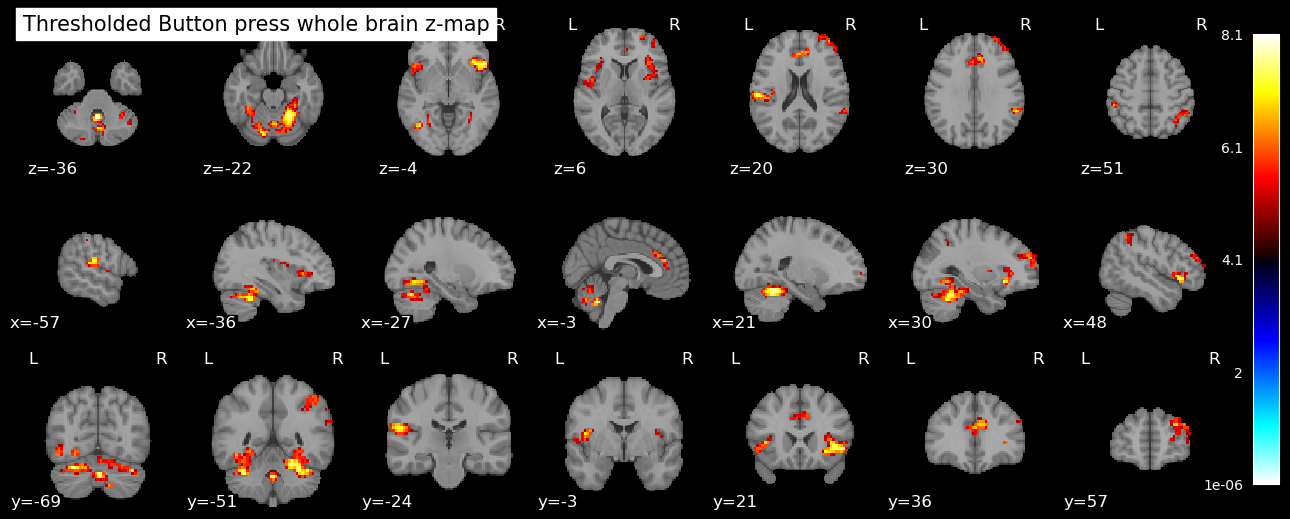

In [52]:
plot_stat_map(thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded Button press whole brain z-map')